__In this notebook, we collect, annotate and pre-process deep mutational scanning (DMS) and alanine scanning (AS) data for future analysis.__

In [2]:
import os
from scipy.stats import spearmanr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
import mavedb_tool as mtool
import preproc as preproc

Duplicate key in file '/Users/fu.j/.matplotlib/matplotlibrc', line 2 ('backend: TkAgg')


In [57]:
data_info = pd.read_csv('../data/data_info/data_compatibility_221024.csv', index_col=0)

# DMS data

## Download

We download all available DMS data from [MaveDB](https://www.mavedb.org/) by the time this study begins.

In [168]:
for urn_id in ['urn:mavedb:00000081-a-2', 'urn:mavedb:00000105-a-1', 'urn:mavedb:00000106-c-1']:
    #mtool.download_mavedb_score(urn_id, '../data/raw/mavedb_data/')

Downloading: urn:mavedb:00000081-a-2 from MaveDB.
Downloading: urn:mavedb:00000105-a-1 from MaveDB.
Downloading: urn:mavedb:00000106-c-1 from MaveDB.


In [38]:
for urn_id in data_info.dms_id.unique():
    # Temporary, following data to be uploaded to MaveDB.
    if urn_id[:3] != 'urn':
        continue
    # We are going to use score.exp column instead of score column for these datasets. Explained below.
    if urn_id[-4:] == '-exp':
        urn_id = urn_id[:-4]
    #mtool.download_mavedb_score(urn_id, '../data/raw/mavedb_data/')

Downloading: urn:mavedb:00000069-a-1 from MaveDB.
Downloading: urn:mavedb:00000058-a-1 from MaveDB.
Downloading: urn:mavedb:00000003-a-2 from MaveDB.
Downloading: urn:mavedb:00000003-b-2 from MaveDB.
Downloading: urn:mavedb:00000097-0-1 from MaveDB.
Downloading: urn:mavedb:00000001-c-1 from MaveDB.
Downloading: urn:mavedb:00000005-a-5 from MaveDB.
Downloading: urn:mavedb:00000005-a-6 from MaveDB.
Downloading: urn:mavedb:00000047-a-1 from MaveDB.
Downloading: urn:mavedb:00000047-b-1 from MaveDB.
Downloading: urn:mavedb:00000047-c-1 from MaveDB.
Downloading: urn:mavedb:00000046-a-1 from MaveDB.
Downloading: urn:mavedb:00000051-a-1 from MaveDB.
Downloading: urn:mavedb:00000048-a-1 from MaveDB.
Downloading: urn:mavedb:00000048-b-1 from MaveDB.
Downloading: urn:mavedb:00000048-c-1 from MaveDB.
Downloading: urn:mavedb:00000062-b-1 from MaveDB.
Downloading: urn:mavedb:00000062-a-1 from MaveDB.
Downloading: urn:mavedb:00000077-a-1 from MaveDB.
Downloading: urn:mavedb:00000077-b-1 from MaveDB.


## Annotate

We further annotated the downloaded MaveDB data for the analysis of single amino acid variants (SAV).

In this analysis, we only use __experimental DMS scores__ which are usually stored in the `score` column of MaveDB data. But some studies may report __computationally imputed/refined scores__ instead, and store the experimental ones in `exp.score`. So, we swapped these columns in these cases.

For each variant entry:
1. If it is a __single amino acid missense variant__, the wild-type amino acid, variant type amino acid and location of substitution will be recorded
2. If it is a synonymous (or unchanged), nonsense or deletion variant, only the type (synonymous, ...) will be recorded
3. For multi-variants, frameshift or other types of variants, no detailed information will be recorded

In [58]:
annot_data = dict()
for dms_id in data_info.dms_id.unique():
    if dms_id[-4:] == '-exp':
        urn_id = dms_id[:-4]
        # We are going to use score.exp column instead of score column for these datasets.
        mave_data = pd.read_csv(f"../data/raw/mavedb_data/{urn_id}.csv", header=4)
        mave_data['score'] = mave_data['exp.score']
        mave_data = mave_data.drop(columns='exp.score')
    else:
        urn_id = dms_id
        mave_data = pd.read_csv(f"../data/raw/mavedb_data/{urn_id}.csv", header=4)
        if urn_id == 'urn:mavedb:00000097-0-1':  # Special hgvs_pro format.
            mave_data = mave_data[mave_data['hgvs_pro'].notna()]  # Remove non-coding variants.
            mave_data['hgvs_pro'] = mave_data.hgvs_pro.str[12:]
    
    mave_data = mtool.clean_mavedb_scores(mave_data)
    mave_data = mtool.annotate_mavedb_sav_data(mave_data)
    mave_data['dms_id'] = dms_id
    annot_data[dms_id] = mave_data

## Normalize

We normalize each DMS dataset by the scores of wildtype-like (wildtype or synonymous) and nonsense-like variants. Only single amino acid missense variant will be kept after this process.

__For wildtype-like scores__, we use the scores of synonymous variants in the data, if available. Otherwise, we referred to the paper, especially the method for score calculation, to identify the wildtype-like scores, as shown in the below cell.

__For nonsense-like scores__, it is defined as the median DMS scores for the 1% missense variants with the strongest loss of function in each DMS dataset, which are usually lower in scores (indicated as `negative`). But in some cases, according to the paper, high DMS scores may represent loss of protein functions (indicated as `positive`). We listed these datasets with positive-losss below for a correct normalisation.

In [59]:
defined_wt_scores = {'urn:mavedb:00000004-a-1': 0,  # Indicated by score calculation.
                     'urn:mavedb:00000010-a-1': 1,  # Defined by the paper.
                     'urn:mavedb:00000012-a-1': 0,  # Indicated by score calculation.
                     'urn:mavedb:00000012-a-2': 0,  # Indicated by score calculation.,
                     'urn:mavedb:00000012-a-3': 0,  # Indicated by score calculation.,
                     'urn:mavedb:00000012-a-4': 0,  # Indicated by score calculation.,
                     'urn:mavedb:00000012-a-5': 0,  # Indicated by score calculation.,
                     'urn:mavedb:00000012-a-6': 0,  # Indicated by score calculation.,
                     'urn:mavedb:00000041-a-1': 0,  # Defined by the paper.
                     'urn:mavedb:00000041-b-1': 0,  # Defined by the paper.
                     'urn:mavedb:00000053-a-2': 0,  # Defined by the paper.
                     'urn:mavedb:00000060-a-1': 0,  # Defined by the paper.
                     'urn:mavedb:00000060-a-2': 0,  # Defined by the paper.
                     'urn:mavedb:00000062-b-1': 0.7050428,  # Referred from urn:mavedb:00000062-a-1
                     'urn:mavedb:00000077-b-1': 0,  # Indicated by score calculation.
                     'urn:mavedb:00000079-a-1': 0,  # Indicated by score calculation.
                     'urn:mavedb:00000086-a-1': 0,  # Defined by the paper.
                     'urn:mavedb:00000086-b-1': 0,  # Defined by the paper.
                     'urn:mavedb:00000086-c-1': 0,  # Defined by the paper.
                     'urn:mavedb:00000086-d-1': 0,  # Defined by the paper.
                     'urn:mavedb:00000086-e-1': 0,  # Defined by the paper.
                     'urn:mavedb:00000086-f-1': 0,  # Defined by the paper.
                     'urn:mavedb:00000086-g-1': 0,  # Defined by the paper.
                     'urn:mavedb:00000081-a-2': 0,  # Indicated by score calculation.
                     'tmp:UCrl0vQc6AQv4KH4': 1,  # Indicated by score calculation.
                     }

# Nonsense-like variants in the following DMS data have positive scores, either identified according 
# to assay setup or directly from scores of nonsense variants.
positive_loss = ['urn:mavedb:00000041-a-1', 'urn:mavedb:00000041-b-1', 'urn:mavedb:00000045-a-1', 
                 'urn:mavedb:00000045-b-1', 'urn:mavedb:00000045-c-1', 'urn:mavedb:00000045-d-1', 
                 'urn:mavedb:00000045-e-1', 'urn:mavedb:00000045-f-1', 'urn:mavedb:00000045-g-1', 
                 'urn:mavedb:00000045-h-1', 'urn:mavedb:00000045-i-1', 'urn:mavedb:00000045-j-1', 
                 'urn:mavedb:00000045-k-1', 'urn:mavedb:00000045-l-1', 'urn:mavedb:00000051-a-1', 
                 'urn:mavedb:00000051-b-1', 'urn:mavedb:00000060-a-1', 'urn:mavedb:00000060-a-2', 
                 'urn:mavedb:00000076-a-1', 'urn:mavedb:00000076-b-1', 'urn:mavedb:00000076-c-1', 
                 'urn:mavedb:00000076-e-1', 'urn:mavedb:00000051-c-1', 'urn:mavedb:00000058-a-1', 
                 'urn:mavedb:00000059-a-1', 'urn:mavedb:00000068-b-1']

In [60]:
normed_data = dict()
for dms_id, input_data in annot_data.items():
    # Theses data are specially normalised as shown below.
    if dms_id in ['urn:mavedb:00000105-a-1', 'urn:mavedb:00000054-a-1']: 
        continue
        
    # Set wildtype-like and nonsense-variant-like scores.
    wt_score = mtool.get_dms_wiltype_like_score(input_data)
    if np.isnan(wt_score):
        wt_score = defined_wt_scores[dms_id]
    if dms_id in positive_loss:
        non_score = 'positive'
    else:
        non_score = 'negative'
        
    data = input_data.query("mut_type == 'missense'").copy()
    data = preproc.normalize_dms_score(data, wt_score, non_score)
    normed_data[dms_id] = data

In [61]:
# In this dataset, the original scoring methods is not log-transformed but most other DMS data are.
dms_id = 'urn:mavedb:00000105-a-1'
input_data = annot_data[dms_id]

data = input_data.query("mut_type == 'missense'").copy()
data['score'] = np.log(data['score'])  # log-transformation.
wt_score = 0  # Indicated by score calculation (original: 1, log-transformed: 0).
non_score = 'negative'
data = preproc.normalize_dms_score(data, wt_score, non_score)
normed_data[dms_id] = data

In [62]:
# Wildtype score of this data is questionable. Corrected score is confirmed from the paper.
dms_id = 'urn:mavedb:00000054-a-1'
input_data = annot_data[dms_id]

wt_score = 0  # Corrected.
non_score = 'negative'

data = input_data.query("mut_type == 'missense'").copy()
data = preproc.normalize_dms_score(data, wt_score, non_score)
normed_data[dms_id] = data

## Position mapping

We then map each DMS residue to the reference protein sequence from UniProt.

To do this, we first curated the `UniProtKB ID` for each DMS target and added the rational `offset` between DMS variant position and reference sequence in `data_info`.

Residues conform with the reference sequence will be kept, adding its position in the reference sequence. Otherwise the residue will be removed with notice.

In [63]:
def get_uniprot_seq(uniprot_id):
    """Read UniProt sequence as pandas.Series format from reference folder.
    """
    with open(f"../data/reference/{uniprot_id}.fasta", 'r') as file:
        str_seq = file.read()
    str_seq = ''.join(str_seq.split('\n')[1:-1])
    # Adding 1 to make the positions start with 1 rather than 0.
    pro_seq = pd.Series(dict(zip(np.arange(len(str_seq))+1, str_seq)))
    return pro_seq


def get_uniprot_matched_dms_residues(dms_id, dms_seq, pro_seq):
    """
    The function reports mismatched DMS residues compared to the UniProt sequence. Then it returns 
    the matched DMS residues in a list.
    """
    matched_dms_seq = dms_seq.copy()  # This is for visualizing the final matched sequence.
    matched_res = []
    # Go through each DMS residue to check with reference sequence.
    for i, upos_res in enumerate(matched_dms_seq.index):
        if matched_dms_seq[upos_res] != pro_seq[upos_res]:
            print(f"Delete: Residue {upos_res}. DMS wildtype: {dms_seq[upos_res]}. UniProt wildtype: {pro_seq[upos_res]}")
            matched_dms_seq[upos_res] = '-'
        else:
            matched_res.append(upos_res)
    print('Matcheded DMS seq.: >',''.join(matched_dms_seq))
    return matched_res

In [64]:
unip_info = data_info.groupby('dms_id')[['uniprot_id', 'offset']].first()

mapped_data = dict()
for dms_id, input_data in normed_data.items():
    # Set UniProt positions.
    unip = unip_info.loc[dms_id]['uniprot_id']
    offset = int(unip_info.loc[dms_id]['offset'])
    input_data['uniprot_id'] = unip
    input_data['u_pos'] = input_data['position'].astype(int) + offset
    
    # Check if DMS indicated protein sequence conforms with UniProt sequence.
    pro_seq = get_uniprot_seq(unip)
    dms_seq = input_data.groupby('u_pos')['aa1'].first()
    if any(dms_seq != pro_seq.loc[dms_seq.index]):
        print(f"MISMATCH FOUND IN {dms_id}:")
        matched_res = get_uniprot_matched_dms_residues(dms_id, dms_seq, pro_seq)
        input_data = input_data[input_data['u_pos'].isin(matched_res)]  # Drop wildtype mismatched residues.
        print('*'*80)
    mapped_data[dms_id] = input_data

MISMATCH FOUND IN urn:mavedb:00000003-a-2:
Delete: Residue 175. DMS wildtype: R. UniProt wildtype: K
Matcheded DMS seq.: > DLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKFCMLKLLNQKKGPSQCPLCKNDITKRSLQESTRFSQLVEELLKIICAFQLDTGLEYANSYNFAKKENNSPHLKDEVSIIQSMGYRNRAKRLLQSEPENPSLQETSLSVQLSNLGTVRTLRTKQRIQPQ-TSVIELGSDSSEDTVNKATYCSVGDQELLQITPQGTRDEISLDSAKKAACEFSETDVTNTEHHQPSNNDLNTTEKRAAERHPEKYQGSSVSNLHVEPCGTNTHASSLQHENSSLLLTKDRMNVEKAEF
********************************************************************************
MISMATCH FOUND IN urn:mavedb:00000003-b-2:
Delete: Residue 175. DMS wildtype: R. UniProt wildtype: K
Matcheded DMS seq.: > DLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKFCMLKLLNQKKGPSQCPLCKNDITKRSLQESTRFSQLVEELLKIICAFQLDTGLEYANSYNFAKKENNSPEHLKDEVSIIQSMGYRNRAKRLLQSEPENPSLQETSLSVQLSNLGTVRTLRTKQRIQPQ-TSVYIELGSDSSEDTVNKATYCSVGDQELLQITPQGTRDEISLDSAKKAACEFSETDVTNTEHHQPSNNDLNTTEKRAAERHPEKYQGSSVSNLHVEPCGTNTHASSLQHENSSLLLTKDRMNVEKAEF
*******************************************************************

In most cases there are only one mismatched residue for each DMS dataset which may related to polymorphism.

Only two DMS datasets show more than one mismatched residues which are all at the start or end of the scanned sequences, that may related to experimental setup.

## Add DeMaSk features

Raw feature values were downloaded from [DeMaSk website](https://demask.princeton.edu/query/), using whole protein sequence.

In [291]:
demask_dms = dict()
for dms_id, input_data in mapped_data.items():
    unip = input_data.iloc[0]['uniprot_id']
    feat_data = pd.read_csv(f"../data/raw/protein_feature/demask/{unip}.txt")
    featured_data = pd.merge(input_data, feat_data, left_on=['u_pos', 'aa1', 'aa2'], 
                             right_on=['pos', 'WT', 'var'], how='left', 
                             suffixes=['', '_online_pred'])
    featured_data['sub_type'] = featured_data['aa1'] + featured_data['aa2']
    demask_dms[dms_id] = featured_data[['dms_id', 'position', 'aa2', 'aa1', 'sub_type', 'score', 
                                        'u_pos', 'uniprot_id', 'entropy', 'log2f_var', 'matrix']]
demask_dms = pd.concat(demask_dms.values(), ignore_index=True)
demask_dms = demask_dms.astype({'position': int})
#demask_dms.to_csv('../data/normalized/dms_DeMaSk_features_221024.csv')

## Add Envision features

Raw feature values were downloaded from [Envision website](https://envision.gs.washington.edu/shiny/envision_new/).

Protein data were excluded if their feature values were not available. 

In [65]:
envision_feature_map = {
    "AA1": "aa1",
    "AA2": "aa2",
    "WT_Mut": "wt_mut",
    "AA1_polarity": "aa1_polarity",
    "AA2_polarity": "aa2_polarity",
    "AA1_pI": "aa1_PI",
    "AA2_pI": "aa2_PI",
    "AA1_weight": "aa1_weight",
    "AA2_weight": "aa2_weight",
    "AA1_volume": "aa1vol",
    "AA2_volume": "aa2vol",
    "AA1_PSIC": "aa1_psic",
    "AA2_PSIC": "aa2_psic",
    "delta_PSIC": "delta_psic",
    "solvent_accessibility": "accessibility",
    "SecondaryStructure": "dssp_sec_str",
    "phi_psi_angles": "phi_psi_reg",
    "Uniprot": "uniprot_id",
    "position": "u_pos",
}

In [361]:
envision_dms = dict()
for dms_id, input_data in mapped_data.items():
    input_data = input_data[['dms_id', 'position', 'aa2', 'aa1', 'score', 'u_pos', 'uniprot_id']].copy()
    unip = input_data.iloc[0]['uniprot_id']
    
    try:
        feat_data = pd.read_csv(f"../data/raw/protein_feature/envision/{unip}_envisionData.csv", 
                                index_col=0, na_values=[''], keep_default_na=False)
    except FileNotFoundError:
        print(f"{dms_id} ({unip}) has no Envision feature and will be removed.")
        continue
    feat_data = feat_data.rename(columns=envision_feature_map)
    # Drop not used columns.
    feat_data = feat_data.drop(columns=['X1', 'id2', 'Variant', 'evolutionary_coupling_prop', 
                                        'evolutionary_coupling_avg_norm', 'Envision_predictions'])
    feat_data = feat_data.astype({"u_pos": int})
    feat_data['wt_mut'] = feat_data['aa1'] + feat_data['aa2']
    
    featured_data = pd.merge(input_data, feat_data, left_on=['uniprot_id', 'u_pos', 'aa1', 'aa2'], 
                             right_on=['uniprot_id', 'u_pos', 'aa1', 'aa2'], how='left')
    envision_dms[dms_id] = featured_data
    
envision_dms = pd.concat(envision_dms.values(), ignore_index=True)
envision_dms = envision_dms.astype({'position': int})
#envision_dms.to_csv('../data/normalized/dms_Envision_features_221024.csv')

urn:mavedb:00000001-c-1 (P0DP23) has no Envision feature and will be removed.
urn:mavedb:00000077-a-1 (Q06851) has no Envision feature and will be removed.
urn:mavedb:00000077-b-1 (B8I7V0) has no Envision feature and will be removed.
urn:mavedb:00000063-a-1 (P0ABQ4) has no Envision feature and will be removed.
urn:mavedb:00000063-b-1 (P0ABQ4) has no Envision feature and will be removed.
urn:mavedb:00000090-a-1 (P31016) has no Envision feature and will be removed.
urn:mavedb:00000090-b-1 (P31016) has no Envision feature and will be removed.
urn:mavedb:00000076-a-1 (P40515) has no Envision feature and will be removed.
urn:mavedb:00000076-b-1 (P40515) has no Envision feature and will be removed.
urn:mavedb:00000076-c-1 (P40515) has no Envision feature and will be removed.
urn:mavedb:00000076-e-1 (P40515) has no Envision feature and will be removed.
urn:mavedb:00000011-a-1 (P02829) has no Envision feature and will be removed.
urn:mavedb:00000039-a-1 (P02829) has no Envision feature and wil

In [363]:
envision_dms.isna().any()

dms_id                         False
position                       False
aa2                            False
aa1                            False
score                          False
u_pos                          False
uniprot_id                     False
wt_mut                         False
aa1_polarity                   False
aa2_polarity                   False
aa1_PI                         False
aa2_PI                         False
deltaPI                        False
aa1_weight                     False
aa2_weight                     False
deltaWeight                    False
aa1vol                         False
aa2vol                         False
deltavolume                    False
Grantham                        True
aa1_psic                        True
aa2_psic                        True
delta_psic                      True
accessibility                   True
dssp_sec_str                    True
phi_psi_reg                     True
delta_solvent_accessibility     True
b

### Add Envision features + paper derived

In [66]:
env_supp = pd.read_csv('/Users/fu.j/AnacondaProjects/Envision2017-master/data/dmsTraining_2017-02-20.csv')
env_supp = env_supp[env_supp['mut_type']=='missense']
env_supp['wt_mut'] = env_supp['aa1'] + env_supp['aa2']
env_supp = env_supp[['uniprot_id', 'aa1', 'aa2', 'wt_mut', 'position', 'aa1_polarity', 'aa2_polarity', 
     'aa1_PI', 'aa2_PI', 'deltaPI', 'aa1_weight', 'aa2_weight', 'deltaWeight', 'aa1vol', 
     'aa2vol', 'deltavolume', 'Grantham', 'aa1_psic', 'aa2_psic', 'delta_psic', 'accessibility',
     'dssp_sec_str', 'phi_psi_reg', 'delta_solvent_accessibility', 'b_factor', 'mut_msa_congruency', 
     'mut_mut_msa_congruency', 'seq_ind_closest_mut', 'evolutionary_coupling_avg']].drop_duplicates()

paper_derive_unips = ['P06654', 'P02829', 'P62593', 'P31016']
supp_feat = env_supp.query("uniprot_id in @paper_derive_unips")
supp_feat[['uniprot_id', 'position', 'aa2']].duplicated().any()  # Variant entries are unique.

False

In [67]:
clean_supp_feat = []
for unip, input_data in supp_feat.groupby('uniprot_id'):
    offset = 0
    input_data['u_pos'] = input_data['position'].astype(int) + offset
    
    grouped = input_data.groupby('u_pos')['aa1']
    if (grouped.nunique()!=1).any():
        raise ValueError('None unique wildt-ype amino acid!')
    dms_seq = grouped.first()
    
    # Check if protein sequence conforms with UniProt sequence.
    pro_seq = get_uniprot_seq(unip)
    if any(dms_seq != pro_seq.loc[dms_seq.index]):
        print(f"MISMATCH FOUND IN {unip}:")
        matched_res = get_uniprot_matched_dms_residues(unip, dms_seq, pro_seq)
        input_data = input_data[input_data['u_pos'].isin(matched_res)]  # Drop wildtype mismatched residues.
        print('*'*80)
    else:
        print(f"PERFECT MATCH FOR {unip}")
        
    clean_supp_feat.append(input_data.drop(columns='position'))
clean_supp_feat = pd.concat(clean_supp_feat, ignore_index=True)

PERFECT MATCH FOR P02829
MISMATCH FOUND IN P06654:
Delete: Residue 228. DMS wildtype: Q. UniProt wildtype: T
Matcheded DMS seq.: > -YKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
********************************************************************************
PERFECT MATCH FOR P31016
PERFECT MATCH FOR P62593


/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [110]:
envision_dms_extra = dict()
for dms_id, input_data in mapped_data.items():
    input_data = input_data[['dms_id', 'position', 'aa2', 'aa1', 'score', 'u_pos', 'uniprot_id']].copy()
    unip = input_data.iloc[0]['uniprot_id']
    
    if unip not in ['P06654', 'P02829', 'P62593', 'P31016']:
        try:
            feat_data = pd.read_csv(f"../data/raw/protein_feature/envision/{unip}_envisionData.csv", 
                                    index_col=0, na_values=[''], keep_default_na=False)
        except FileNotFoundError:
            print(f"{dms_id} ({unip}) has no Envision feature and will be removed.")
            continue
        feat_data = feat_data.rename(columns=envision_feature_map)
        # Drop not used columns.
        feat_data = feat_data.drop(columns=['X1', 'id2', 'Variant', 'evolutionary_coupling_prop', 
                                            'evolutionary_coupling_avg_norm', 'Envision_predictions'])
        feat_data = feat_data.astype({"u_pos": int})
    else:
        feat_data = clean_supp_feat.query("uniprot_id == @unip")
    
    featured_data = pd.merge(input_data, feat_data, left_on=['uniprot_id', 'u_pos', 'aa1', 'aa2'], 
                             right_on=['uniprot_id', 'u_pos', 'aa1', 'aa2'], how='left')
    envision_dms_extra[dms_id] = featured_data
    
envision_dms_extra = pd.concat(envision_dms_extra.values(), ignore_index=True)
envision_dms_extra = envision_dms_extra.astype({'position': int})
envision_dms_extra['wt_mut'] = envision_dms_extra['aa1'] + envision_dms_extra['aa2']
#envision_dms_extra.to_csv('../data/normalized/dms_Envision_features_extra_221027.csv')

urn:mavedb:00000001-c-1 (P0DP23) has no Envision feature and will be removed.
urn:mavedb:00000077-a-1 (Q06851) has no Envision feature and will be removed.
urn:mavedb:00000077-b-1 (B8I7V0) has no Envision feature and will be removed.
urn:mavedb:00000063-a-1 (P0ABQ4) has no Envision feature and will be removed.
urn:mavedb:00000063-b-1 (P0ABQ4) has no Envision feature and will be removed.
urn:mavedb:00000076-a-1 (P40515) has no Envision feature and will be removed.
urn:mavedb:00000076-b-1 (P40515) has no Envision feature and will be removed.
urn:mavedb:00000076-c-1 (P40515) has no Envision feature and will be removed.
urn:mavedb:00000076-e-1 (P40515) has no Envision feature and will be removed.
urn:mavedb:00000064-a-1 (P02943) has no Envision feature and will be removed.
urn:mavedb:00000064-b-1 (P02943) has no Envision feature and will be removed.
urn:mavedb:00000079-a-1 (A0A3G4RHW3_ATRBE) has no Envision feature and will be removed.
urn:mavedb:00000080-a-2 (P42212) has no Envision featu

In [111]:
envision_dms_extra.isna().any()

dms_id                         False
position                       False
aa2                            False
aa1                            False
score                          False
u_pos                          False
uniprot_id                     False
wt_mut                         False
aa1_polarity                    True
aa2_polarity                    True
aa1_PI                          True
aa2_PI                          True
deltaPI                         True
aa1_weight                      True
aa2_weight                      True
deltaWeight                     True
aa1vol                          True
aa2vol                          True
deltavolume                     True
Grantham                        True
aa1_psic                        True
aa2_psic                        True
delta_psic                      True
accessibility                   True
dssp_sec_str                    True
phi_psi_reg                     True
delta_solvent_accessibility     True
b

# AS data

We searched for alanine scanning studies with key phrase `(alanine scanning) OR (alanine scan)` together with protein names or identifiers with DMS data available.

Appropriate AS data were collected and curated if:
* they match the target protein
* they are in numeric format
* their wildtype-like and nonsense-like scores are available (tested or can be identified)
* they contain single alanine substitutions
* they are experimental rather than computational scores

Raw published values are curated in the `score` column for input data. For results presented in bar plots, we measured and stored the length of each bar. For results presented in Western blot, we used ImageJ to quantify the intensity for each entry. Residue positions are mapped and checked to UniProt sequences.

AS scores are normalized in a same way as DMS, except that the nonsense-like scores are defined from the experiment directly (more details in `note` column).

In [640]:
root = '../data/raw/low-throughput_data/'
norm_as = []
for file_name in os.listdir(root):
    if file_name == '.DS_Store':
        continue
    ascan_id = file_name[:-4]
    as_data = pd.read_csv(f"{root}{file_name}", index_col=0)
    
    nons = float(as_data.loc[as_data['aa1'] == 'non', 'score'])
    wts = float(as_data.loc[as_data['aa1'] == 'wt', 'score'])
    as_data = as_data[as_data['aa2'] == 'A']
    as_data = as_data.astype({'u_pos': int, 'position': int}).rename(columns={'score': 'AS_score'})
    as_data['AS_score'] = (as_data['AS_score'] - nons) / (wts - nons)  # Normalize.
    norm_as.append(as_data)
    
norm_as = pd.concat(norm_as, ignore_index=True)
#norm_as.to_csv('../data/normalized/as_data_221024.csv')

# DMS-AS correlation

We then calculate the Spearman's correlation between each DMS-AS pair.  

We first merge (map) each DMS and AS data by protein positions, and add information about the DMS-AS pair.

Then the correlation and regularized correlation values are calculate between __AS scores__ and __DMS scores of alanine substitutions__.

In [295]:
# Merge in a cartesian product way.
dms_all_as = pd.merge(demask_dms, norm_as[['uniprot_id', 'u_pos', 'Ascan_id', 'AS_score']], 
                      on=['uniprot_id', 'u_pos'], how='left')

# Identifier for each DMS+AS combined dataset.
dms_all_as['dmsa_id'] = dms_all_as['dms_id'] + '@' + dms_all_as['Ascan_id'].astype(str)
dms_all_as['Ascan_score_avail'] = ~dms_all_as['AS_score'].isna()

In [322]:
corr_stat = []
for dmsa, df in dms_all_as.groupby('dmsa_id'):
    if dmsa[-4:] == '@nan':  # No AS data available.
        continue
        
    df = df[df['aa2'] == 'A']
    row = dict()
    row['dmsa_id'] = dmsa
    row['n_ala'] = len(df)
    corr = spearmanr(df['score'], df['AS_score'])[0]
    if np.isnan(corr):
        # Impute missing value by 0 which is caused by only one or no alanine residue available.
        row['ala_score_correlation'] = 0.
    else:
        row['ala_score_correlation'] = corr
    row['regularized_correlation'] = (row['n_ala']-1) / (row['n_ala']+1) * row['ala_score_correlation']
    corr_stat.append(row)
    
# Right merge: some DMS and AS data have no overlapping residues (e.g.: urn:mavedb:00000003-a-2@brca1_yeast_growth),
# that should be removed.
data_corr = pd.merge(data_info, pd.DataFrame(corr_stat), on='dmsa_id', how='right', validate='1:1')
#data_corr.to_csv('../data/data_info/dms_as_info_221024.csv')

# Working data (TO BE REMOVED)

## New check

In [293]:
foo = pd.read_csv('../data/normalized/new_temp_normalized_dms_DeMaSk_features.csv', 
                  index_col=0, na_values=[''], keep_default_na=False)
dms_map = {'temp_aicda': 'urn:mavedb:00000106-c-1', 'temp_jun': 'tmp:UCrl0vQc6AQv4KH4', 
           'temp_gb1': 'urn:mavedb:00000105-a-1', 'temp_brca1_starita2018': 'urn:mavedb:00000081-a-2'}
foo = foo.replace(dms_map)
pd.testing.assert_frame_equal(demask_dms.sort_values(['dms_id', 'position', 'aa2']).reset_index(drop=True)[foo.columns], 
                              foo.sort_values(['dms_id', 'position', 'aa2']).reset_index(drop=True))

## MaveDB source

In [3]:
dms_data = []

root = '/Users/fu.j/AnacondaProjects/Project_3_extrapolation_model/data/dms_data/normalized_data/version_221005/uniprot_mapped/'
files = os.listdir(root)
files.sort()
for file_name in files:
    if file_name in ['.DS_Store']:
        continue    
    dms_data.append(pd.read_csv(f"{root}{file_name}", index_col=0))
dms_data = pd.concat(dms_data)

## Local

In [7]:
import re
sys.path.append('/Users/fu.j/PycharmProjects/FirstPyCharm/')
import mavedb_tool.mavedb_tool as mtool


def annotate_single_mutation(urn_data):
    if_single = []
    pos_list = []
    aa1_list = []
    aa2_list = []
    mut_type = []
    for mutation in urn_data["hgvs_pro"]:
        # Remove multiple mutation (e.g.: p.[...]), uncertain mutation (e.g.: p.Met1?), stoploss 
        # variant (e.g.: p.Ter...) and deletion-insertion (e.g.: p.Cys28delinsTrpVal).
        found = re.search("delins", mutation)
        if (
            (mutation[-1] == "]")
            | (mutation[-1] == "?")
            | (mutation[2:5] == "Ter")
            | (found is not None)
        ):
            pos_list.append("np.nan")
            aa1_list.append("np.nan")
            aa2_list.append("np.nan")
            mut_type.append("np.nan")

        else:  # Single mutation.
            aa1 = mtool.par.AMINO_ACID_SINGLE.get(mutation[2:5], "np.nan")
            aa1_list.append(aa1)
            # Synonymous mutation / no change. e.g.: p.=, p.Met1=, p.(=), _wt, _sy.
            # Refs: https://www.mavedb.org/docs/mavehgvs/spec.html
            # https://www.hgvs.org/mutnomen/recs-prot.html
            if (mutation[-1] == "=") | (mutation in ['p.(=)', '_wt', '_sy']):  
                if len(mutation) >= 6:
                    pos_list.append(
                        int(mutation[5:-1])
                    )  # Set to int for checking and sorting.
                else:
                    pos_list.append("np.nan")
                aa2_list.append(aa1)
                mut_type.append("synonymous")
            elif mutation[-1] == "*":  # Nonsense mutation.
                pos_list.append(int(mutation[5:-1]))
                aa2_list.append("Ter")
                mut_type.append("nonsense")
            elif mutation[-3:] == "Ter":  # Nonsense mutation.
                pos_list.append(int(mutation[5:-3]))
                aa2_list.append("Ter")
                mut_type.append("nonsense")
            elif mutation[-3:] == "del":  # Deletion.
                try:
                    pos_list.append(int(mutation[5:-3]))
                except ValueError:  # Example: p.Arg189_Lys190del.
                    print("Not recognised deletion:", mutation)
                    pos_list.append("np.nan")
                aa2_list.append("del")
                mut_type.append("deletion")
            elif re.search("fs", mutation):  # Frame shift.
                try:
                    pos_list.append(int(mutation[5:-2]))
                except ValueError:  # Example: p.Asn234Thrfs*5.
                    print("Not recognised frame shift:", mutation)
                    pos_list.append("np.nan")
                aa2_list.append("fs")
                mut_type.append("frame shift")
            else:  # Missense mutation
                pos_list.append(int(mutation[5:-3]))
                aa2 = mtool.par.AMINO_ACID_SINGLE[mutation[-3:]]
                aa2_list.append(aa2)
                if aa1 != aa2:
                    mut_type.append("missense")
                else:
                    mut_type.append("synonymous")  # This can happen.

    # Assign first then select, in case it is miss matched.
    urn_data["position"] = pos_list
    urn_data["aa1"] = aa1_list
    urn_data["aa2"] = aa2_list
    urn_data["mut_type"] = mut_type
    return urn_data


def convert_mavedb_to_dms(mavedb_data, dms_id):
    mavedb_data = mtool.par.clean_scores(mavedb_data)
    mavedb_data = annotate_single_mutation(mavedb_data)
    mavedb_data["dms_id"] = dms_id

    mavedb_data.index = (
        mavedb_data["dms_id"]
        + "_"
        + mavedb_data["position"].astype(str)
        + "_"
        + mavedb_data["aa2"]
    )
    # Test if indices for missense variants are unique.
    if len(mavedb_data.query("mut_type=='missense'")) != len(mavedb_data.query("mut_type=='missense'").index.unique()):
        raise Exception("Index is not unique!")
    return mavedb_data[["score", "dms_id", "position", "aa1", "aa2", "mut_type", "hgvs_pro"]]

In [11]:
def get_wildtype_score(conv_mave):
    syn_data = conv_mave.query("mut_type=='synonymous'")
    syn_hgvs = syn_data['hgvs_pro'].unique()
    if len(syn_data) == 0:
        return np.nan
    for syn_label in ['p.=', 'p.(=)', '_wt', '_sy']:
        if syn_label in syn_hgvs:
            # Should be one row or the same.
            wt_score = syn_data.query("hgvs_pro == @syn_label").iloc[0]['score']
            return wt_score
    
    # Synonymous mutations are measured on each codon.
    wt_score = syn_data['score'].median()
    return wt_score


def normalize_score(work_data, wt_score, non_score):
    # Version 220307
    df = work_data.copy()
    if non_score == 'positive':
        lower_bound = df['score'].sort_values(ascending=False).iloc[:int(len(df) * 0.01)+1].median()  # Plus 1 to avoid small datset.
    elif non_score == 'negative':
        lower_bound = df['score'].sort_values().iloc[:int(len(df) * 0.01)+1].median()  # Plus 1 to avoid small datset.
    else:
        raise ValueError(f"Wrong non_score input: {non_score}")
    df['score'] = 1 - (df['score'] - wt_score) / (lower_bound - wt_score)
    return df

In [84]:
def get_protein_seq_from_uniprot(uniprot_id):
    # 221005 version.
    with open(f"/Users/fu.j/AnacondaProjects/Project_2_Enlarged_data/Uniprot_data/{uniprot_id}.fasta", 'r') as file:
        str_seq = file.read()
    str_seq = ''.join(str_seq.split('\n')[1:-1])
    pro_seq = pd.Series(dict(zip(np.arange(len(str_seq))+1, str_seq)))
    return pro_seq


def correct_mismatch_seq(dms_id, dms_seq, pro_seq):
    mapped_dms_seq = dms_seq.copy()
    mapped_res = []
    print(f"MISMATCH FOUND IN {dms_id}:")
    for i, upos_res in enumerate(mapped_dms_seq.index):
        if mapped_dms_seq[upos_res] != pro_seq[upos_res]:
            print(f"Deleting: Residue {upos_res}. DMS wildtype: {dms_seq[upos_res]}. UniProt wildtype: {pro_seq[upos_res]}")
            mapped_dms_seq[upos_res] = '-'
        else:
            mapped_res.append(upos_res)
    print('Corrected DMS seq.: >',''.join(mapped_dms_seq))
    print('*'*80)
    return mapped_res

In [17]:
root = '/Users/fu.j/AnacondaProjects/Project_3_extrapolation_model/new_dms/MAVEdb_share_box/'
files = {'temp_jun': 'Diss2018_JUN&FOS/formatted/jun_sav_score.csv',
         'temp_aicda': 'Gajula2014_AICDA/formatted/aicda_G3_score.csv',
         'temp_gb1': 'Olson2014_GB1/mavedb_format/gb1_score.csv',
         'temp_brca1_starita2018': 'Starita2018_BRCA1/formatted/brca1_trial_score.csv'}

In [18]:
# Correction: supported by MaveDB method section that the synonymous scores are 0 centered.
#dms_wt_score['urn:mavedb:00000054-a-1'] = 0

defined_wt_scores = {'urn:mavedb:00000004-a-1': 0,  # Indicated by score calculation.
                     'urn:mavedb:00000010-a-1': 1,  # Defined by the paper.
                     'urn:mavedb:00000012-a-1': 0,  # Indicated by score calculation.
                     'urn:mavedb:00000012-a-2': 0,  # Indicated by score calculation.,
                     'urn:mavedb:00000012-a-3': 0,  # Indicated by score calculation.,
                     'urn:mavedb:00000012-a-4': 0,  # Indicated by score calculation.,
                     'urn:mavedb:00000012-a-5': 0,  # Indicated by score calculation.,
                     'urn:mavedb:00000012-a-6': 0,  # Indicated by score calculation.,
                     'urn:mavedb:00000041-a-1': 0,  # Defined by the paper.
                     'urn:mavedb:00000041-b-1': 0,  # Defined by the paper.
                     'urn:mavedb:00000053-a-2': 0,  # Defined by the paper.
                     'urn:mavedb:00000060-a-1': 0,  # Defined by the paper.
                     'urn:mavedb:00000060-a-2': 0,  # Defined by the paper.
                     'urn:mavedb:00000062-b-1': 0.7050428,  # Taken from urn:mavedb:00000062-a-1
                     'urn:mavedb:00000077-b-1': 0,  # Indicated by score calculation.
                     'urn:mavedb:00000079-a-1': 0,  # Indicated by score calculation.
                     'urn:mavedb:00000086-a-1': 0,  # Defined by the paper.
                     'urn:mavedb:00000086-b-1': 0,  # Defined by the paper.
                     'urn:mavedb:00000086-c-1': 0,  # Defined by the paper.
                     'urn:mavedb:00000086-d-1': 0,  # Defined by the paper.
                     'urn:mavedb:00000086-e-1': 0,  # Defined by the paper.
                     'urn:mavedb:00000086-f-1': 0,  # Defined by the paper.
                     'urn:mavedb:00000086-g-1': 0,  # Defined by the paper.
                     'temp_brca1_starita2018': 0,  # Indicated by score calculation.
                     'temp_jun': 1,  # Indicated by score calculation.
                     }
#dms_wt_score = {**dms_wt_score, **defined_wt_scores}

In [19]:
# Nonsense-like variants in the following DMS data have positive scores, either identified according 
# to assay setup or directly from scores of nonsense variants.
positive_loss = ['urn:mavedb:00000041-a-1', 'urn:mavedb:00000041-b-1', 'urn:mavedb:00000045-a-1', 
                 'urn:mavedb:00000045-b-1', 'urn:mavedb:00000045-c-1', 'urn:mavedb:00000045-d-1', 
                 'urn:mavedb:00000045-e-1', 'urn:mavedb:00000045-f-1', 'urn:mavedb:00000045-g-1', 
                 'urn:mavedb:00000045-h-1', 'urn:mavedb:00000045-i-1', 'urn:mavedb:00000045-j-1', 
                 'urn:mavedb:00000045-k-1', 'urn:mavedb:00000045-l-1', 'urn:mavedb:00000051-a-1', 
                 'urn:mavedb:00000051-b-1', 'urn:mavedb:00000060-a-1', 'urn:mavedb:00000060-a-2', 
                 'urn:mavedb:00000076-a-1', 'urn:mavedb:00000076-b-1', 'urn:mavedb:00000076-c-1', 
                 'urn:mavedb:00000076-e-1', 'urn:mavedb:00000051-c-1', 'urn:mavedb:00000058-a-1', 
                 'urn:mavedb:00000059-a-1', 'urn:mavedb:00000068-b-1']

In [20]:
convert_data = dict()
for dms, file_name in files.items():
    print(f"{dms} converting")
    mave_data =pd.read_csv(f"{root}{file_name}")
    convert_data[dms] = convert_mavedb_to_dms(mave_data[['hgvs_pro', 'score']], dms)

temp_jun converting
temp_aicda converting
temp_gb1 converting
temp_brca1_starita2018 converting


temp_jun


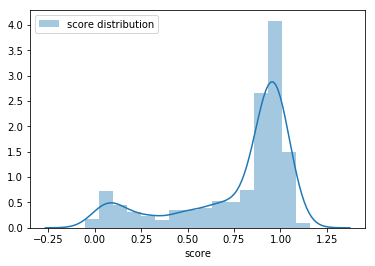

temp_aicda


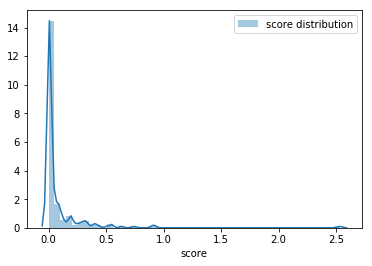

temp_brca1_starita2018


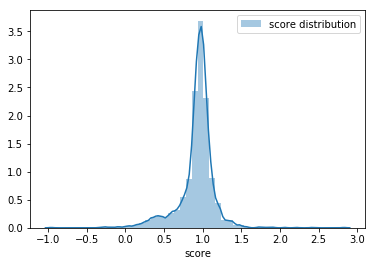

In [82]:
normed_data = dict()
for dms_id, input_data in convert_data.items():
    # Should be specially normalised due to the scoring methods.
    if dms_id in ['temp_gb1']: 
        continue
        
    # Set wildtype-like and nonsense-variant-like scores.
    wt_score = get_wildtype_score(input_data)
    if np.isnan(wt_score):
        wt_score = defined_wt_scores[dms_id]
    if dms_id in positive_loss:
        non_score = 'positive'
    else:
        non_score = 'negative'
        
    data = input_data.query("mut_type == 'missense'").copy()
    data = normalize_score(data, wt_score, non_score)
    normed_data[dms_id] = data
    
    print(dms_id)
    sns.distplot(data['score'], label='score distribution')
    plt.legend()
    plt.show()

temp_gb1


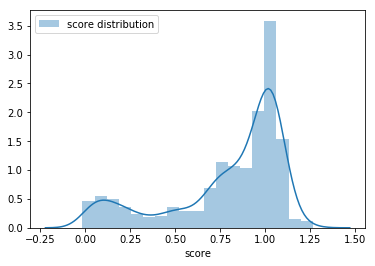

In [83]:
dms_id = 'temp_gb1'
input_data = convert_data[dms_id]

data = input_data.query("mut_type == 'missense'").copy()
data['score'] = np.log(data['score'])  # The scores are not log-transformed but most other DMS data are.
wt_score = 0  # Indicated by score calculation (original: 1, logged: 0).
non_score = 'negative'
data = normalize_score(data, wt_score, non_score)
normed_data[dms_id] = data

print(dms_id)
sns.distplot(data['score'], label='score distribution')
plt.legend()
plt.show()

In [105]:
unip_info = pd.DataFrame({'temp_jun': [276, 'P05412'],
         'temp_aicda': [0, 'Q9GZX7'],
         'temp_gb1': [227, 'P06654'],
         'temp_brca1_starita2018': [0, 'P38398']}, index=['offset', 'uniprot_id']).T

In [109]:
mapped_data = []
for dms_id, input_data in normed_data.items():
    # Set UniProt positions.
    unip = unip_info.loc[dms_id]['uniprot_id']
    offset = int(unip_info.loc[dms_id]['offset'])
    data = input_data.copy()
    data['uniprot_id'] = unip
    data['u_pos'] = data['position'].astype(int) + offset
    
    # Check if DMS indicated protein sequence conforms with UniProt sequence.
    pro_seq = get_protein_seq_from_uniprot(unip)
    dms_seq = data.groupby('u_pos')['aa1'].first()
    if any(dms_seq != pro_seq.loc[dms_seq.index]):
        mapped_res = correct_mismatch_seq(dms_id, dms_seq, pro_seq)
        data = data[data['u_pos'].isin(mapped_res)]  # Drop wild type mismatched positions.
    else:
        print(f"PERFECT MATCH FOR {dms_id}")
        print('*'*80)
    
    mapped_data.append(data)

PERFECT MATCH FOR temp_jun
********************************************************************************
PERFECT MATCH FOR temp_aicda
********************************************************************************
PERFECT MATCH FOR temp_brca1_starita2018
********************************************************************************
MISMATCH FOUND IN temp_gb1:
Deleting: Residue 228. DMS wildtype: Q. UniProt wildtype: T
Corrected DMS seq.: > -YKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
********************************************************************************


In [111]:
dms_data = pd.concat([dms_data]+mapped_data)

## DeMaSk feature

In [124]:
feat_dms = []
for unip, prot_data in dms_data.groupby('uniprot_id'):
    feat_data = pd.read_csv(f"../data/feature/demask/{unip}.txt")
    featured_data = pd.merge(prot_data, feat_data, left_on=['u_pos', 'aa1', 'aa2'], 
                             right_on=['pos', 'WT', 'var'], how='left', 
                             suffixes=['', '_online_pred'])
    featured_data['sub_type'] = featured_data['aa1'] + featured_data['aa2']
    feat_dms.append(featured_data)
feat_dms = pd.concat(feat_dms)

In [ ]:
feat_dms = feat_dms[['dms_id', 'position', 'aa2', 'aa1', 'entropy', 'log2f_var', 'matrix', 'score', 
                     'sub_type', 'u_pos', 'uniprot_id']].reset_index(drop=True)
#feat_dms.to_csv('../data/normalized/new_temp_normalized_dms_DeMaSk_features.csv')

## Info data temp replacement

In [348]:
dmsa_info = pd.read_csv('/Users/fu.j/AnacondaProjects/Project_3_extrapolation_model/data/as_data/221007/221010_compatibility.csv', index_col=0)

In [349]:
replace = {'aicda-g3': 'temp_aicda',
           'brca1-starita2018': 'temp_brca1_starita2018',
           'gb1': 'temp_gb1',
           'jun-full-trans': 'temp_jun'}
dmsa_info.dms_id = dmsa_info.dms_id.replace(replace)
dmsa_info['dmsa_id'] = dmsa_info['dms_id'] + '@' + dmsa_info['Ascan_id']
dmsa_info = dmsa_info[['uniprot_id', 'dms_id', 'protein_name', 'dms_name', 'Ascan_id', 'dmsa_id', 'assumed_compatibility']]

In [350]:
curated_dmsa = pd.read_csv('/Users/fu.j/AnacondaProjects/Project_3_extrapolation_model/data/as_data/221007/temp_extra_dmsa.csv')
curated_dmsa = curated_dmsa[['uniprot_id', 'dms_id', 'protein_name', 'dms_name', 'Ascan_id', 'dmsa_id', 'assumed_compatibility']]
curated_ids = curated_dmsa.dmsa_id
dmsa_info = pd.concat([dmsa_info.query("dmsa_id not in @curated_ids"), curated_dmsa], ignore_index=True)

## Move Envision data

In [339]:
unip_proname_map = data_info.groupby('uniprot_id')['protein_name'].first()

foo = pd.concat(mapped_data.values(), ignore_index=True)
for unip in foo.uniprot_id.unique():
    try:
        pro_data = pd.read_csv(f"/Users/fu.j/AnacondaProjects/Project_2_Enlarged_data/Envision_feature/{unip}_envisionData.csv", 
                    index_col=0)
        #pro_data.to_csv(f"../data/raw/protein_feature/envision/{unip}_envisionData.csv")
    except FileNotFoundError:
        print(unip_proname_map[unip], unip)

/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


CALM1 P0DP23
Cohesin-Cc Q06851
Cohesin-Ct B8I7V0
DHFR P0ABQ4
Dlg4 P31016
FIS1 P40515
HSP90 P02829
LamB P02943
PyKS A0A3G4RHW3_ATRBE
TEM-1 P62593
avGFP P42212
GB1 P06654


## Compare Envision features

In [616]:
old = pd.read_csv('../data/normalized/normalized_dms_Envision_features.csv', 
                  index_col=0, na_values=[''], keep_default_na=False)
new = pd.read_csv('../data/normalized/dms_Envision_features_221024.csv', 
                  index_col=0, na_values=[''], keep_default_na=False)

/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (22,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/fu.j/.conda/envs/ala_proj_finalize/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [617]:
print(set(new.columns) - set(old.columns))
print(set(old.columns) - set(new.columns))
old = old[new.columns]

set()
{'mut_type', 'pos_id'}


In [618]:
data = pd.read_excel('/Users/fu.j/Documents/Manual_results/Dataset_archive.xlsx', sheet_name='DMS')
data = data[data['uniprot_id'].notna()]
dms_urn_map = data.query("mavedb_urn!=dms_id").groupby('dms_id')['mavedb_urn'].first()
dms_urn_map['jun-full-trans'] = 'tmp:UCrl0vQc6AQv4KH4'

old = old.query("uniprot_id not in ['P06654', 'P02829', 'P62593', 'P31016']")
old.dms_id = old.dms_id.replace(dms_urn_map)
rm_new = np.sort(list(set(new.dms_id.unique()) - set(old.dms_id.unique())))
print(rm_new)
new = new.query("dms_id not in @rm_new").sort_values(['dms_id', 'u_pos', 'aa2']).reset_index(drop=True)
rm_old = np.sort(list(set(old.dms_id.unique()) - set(new.dms_id.unique())))
print(rm_old)
old = old.query("dms_id not in @rm_old").sort_values(['dms_id', 'u_pos', 'aa2']).reset_index(drop=True)

['urn:mavedb:00000005-a-5' 'urn:mavedb:00000005-a-6'
 'urn:mavedb:00000035-a-1-exp' 'urn:mavedb:00000035-a-2-exp'
 'urn:mavedb:00000035-a-3-exp' 'urn:mavedb:00000036-a-1-exp'
 'urn:mavedb:00000036-a-2-exp' 'urn:mavedb:00000049-a-1-exp'
 'urn:mavedb:00000049-a-4-exp' 'urn:mavedb:00000049-a-6-exp']
['urn:mavedb:00000005-a-1' 'urn:mavedb:00000005-a-2'
 'urn:mavedb:00000035-a-1' 'urn:mavedb:00000035-a-2'
 'urn:mavedb:00000035-a-3' 'urn:mavedb:00000036-a-1'
 'urn:mavedb:00000036-a-2' 'urn:mavedb:00000049-a-1'
 'urn:mavedb:00000049-a-4' 'urn:mavedb:00000049-a-6']


In [619]:
for dms in new.dms_id.unique():
    if dms in ['urn:mavedb:00000003-a-2', 'urn:mavedb:00000003-b-2', 'urn:mavedb:00000038-a-1']:
        continue
    print(dms)
    new_dms = new.query("dms_id==@dms").copy().reset_index(drop=True)
    old_dms = old.query("dms_id==@dms").copy().reset_index(drop=True)
    new_dms = new_dms.astype({'position': float, 'aa1_weight': float, 'aa2_weight': float, 'deltaWeight': float})
    new_dms = new_dms.drop(columns=['score', 'position'])
    old_dms = old_dms.drop(columns=['score', 'position'])
    pd.testing.assert_frame_equal(new_dms, old_dms)

tmp:UCrl0vQc6AQv4KH4
urn:mavedb:00000001-a-2
urn:mavedb:00000001-a-3
urn:mavedb:00000001-b-2
urn:mavedb:00000001-d-1
urn:mavedb:00000002-a-2
urn:mavedb:00000004-a-1
urn:mavedb:00000010-a-1
urn:mavedb:00000012-a-1
urn:mavedb:00000012-a-2
urn:mavedb:00000012-a-3
urn:mavedb:00000012-a-4
urn:mavedb:00000012-a-5
urn:mavedb:00000012-a-6
urn:mavedb:00000013-a-1
urn:mavedb:00000013-b-1
urn:mavedb:00000037-a-1
urn:mavedb:00000038-b-1
urn:mavedb:00000038-b-2
urn:mavedb:00000041-a-1
urn:mavedb:00000041-b-1
urn:mavedb:00000043-a-1
urn:mavedb:00000045-a-1
urn:mavedb:00000045-b-1
urn:mavedb:00000045-c-1
urn:mavedb:00000045-d-1
urn:mavedb:00000045-e-1
urn:mavedb:00000045-f-1
urn:mavedb:00000045-g-1
urn:mavedb:00000045-h-1
urn:mavedb:00000045-i-1
urn:mavedb:00000045-j-1
urn:mavedb:00000045-k-1
urn:mavedb:00000045-l-1
urn:mavedb:00000046-a-1
urn:mavedb:00000047-a-1
urn:mavedb:00000047-b-1
urn:mavedb:00000047-c-1
urn:mavedb:00000048-a-1
urn:mavedb:00000048-b-1
urn:mavedb:00000048-c-1
urn:mavedb:00000049

In [620]:
for dms in ['urn:mavedb:00000003-a-2', 'urn:mavedb:00000003-b-2', 'urn:mavedb:00000038-a-1']:
    print(dms)
    new_dms = new.query("dms_id==@dms").copy().reset_index(drop=True)
    print('new', len(new_dms))
    old_dms = old.query("dms_id==@dms").copy().reset_index(drop=True)
    print('old', len(old_dms))
    mave = pd.read_csv(f"../data/raw/mavedb_data/{dms}.csv", header=4)
    print('mave', sum(mave[['hgvs_pro']].drop_duplicates()['hgvs_pro'].str[2]!='['))

urn:mavedb:00000003-a-2
new 3701
old 8558
mave 4635
urn:mavedb:00000003-b-2
new 4132
old 5880
mave 4635
urn:mavedb:00000038-a-1
new 1380
old 2465
mave 1528


### paper derived

In [112]:
old = pd.read_csv('../data/normalized/normalized_dms_Envision_features.csv', 
                  index_col=0, na_values=[''], keep_default_na=False)
new = pd.read_csv('../data/normalized/dms_Envision_features_extra_221027.csv', 
                  index_col=0, na_values=[''], keep_default_na=False)

In [113]:
print(set(new.columns) - set(old.columns))
print(set(old.columns) - set(new.columns))
old = old[new.columns]

set()
{'mut_type', 'pos_id'}


In [114]:
data = pd.read_excel('/Users/fu.j/Documents/Manual_results/Dataset_archive.xlsx', sheet_name='DMS')
data = data[data['uniprot_id'].notna()]
dms_urn_map = data.query("mavedb_urn!=dms_id").groupby('dms_id')['mavedb_urn'].first()
dms_urn_map['jun-full-trans'] = 'tmp:UCrl0vQc6AQv4KH4'

old.dms_id = old.dms_id.replace(dms_urn_map)
rm_new = np.sort(list(set(new.dms_id.unique()) - set(old.dms_id.unique())))
print(rm_new)
new = new.query("dms_id not in @rm_new").sort_values(['dms_id', 'u_pos', 'aa2']).reset_index(drop=True)
rm_old = np.sort(list(set(old.dms_id.unique()) - set(new.dms_id.unique())))
print(rm_old)
old = old.query("dms_id not in @rm_old").sort_values(['dms_id', 'u_pos', 'aa2']).reset_index(drop=True)

['urn:mavedb:00000005-a-5' 'urn:mavedb:00000005-a-6'
 'urn:mavedb:00000035-a-1-exp' 'urn:mavedb:00000035-a-2-exp'
 'urn:mavedb:00000035-a-3-exp' 'urn:mavedb:00000036-a-1-exp'
 'urn:mavedb:00000036-a-2-exp' 'urn:mavedb:00000049-a-1-exp'
 'urn:mavedb:00000049-a-4-exp' 'urn:mavedb:00000049-a-6-exp']
['urn:mavedb:00000005-a-1' 'urn:mavedb:00000005-a-2'
 'urn:mavedb:00000035-a-1' 'urn:mavedb:00000035-a-2'
 'urn:mavedb:00000035-a-3' 'urn:mavedb:00000036-a-1'
 'urn:mavedb:00000036-a-2' 'urn:mavedb:00000049-a-1'
 'urn:mavedb:00000049-a-4' 'urn:mavedb:00000049-a-6']


In [116]:
for dms in new.dms_id.unique():
    if dms in ['urn:mavedb:00000003-a-2', 'urn:mavedb:00000003-b-2', 'urn:mavedb:00000038-a-1']:
        continue
    print(dms)
    new_dms = new.query("dms_id==@dms").copy().reset_index(drop=True)
    old_dms = old.query("dms_id==@dms").copy().reset_index(drop=True)
    new_dms = new_dms.astype({'position': float, 'aa1_weight': float, 'aa2_weight': float, 'deltaWeight': float})
    new_dms = new_dms.drop(columns=['score', 'position'])
    old_dms = old_dms.drop(columns=['score', 'position'])
    pd.testing.assert_frame_equal(new_dms, old_dms)

tmp:UCrl0vQc6AQv4KH4
urn:mavedb:00000001-a-2
urn:mavedb:00000001-a-3
urn:mavedb:00000001-b-2
urn:mavedb:00000001-d-1
urn:mavedb:00000002-a-2
urn:mavedb:00000004-a-1
urn:mavedb:00000010-a-1
urn:mavedb:00000011-a-1
urn:mavedb:00000012-a-1
urn:mavedb:00000012-a-2
urn:mavedb:00000012-a-3
urn:mavedb:00000012-a-4
urn:mavedb:00000012-a-5
urn:mavedb:00000012-a-6
urn:mavedb:00000013-a-1
urn:mavedb:00000013-b-1
urn:mavedb:00000037-a-1
urn:mavedb:00000038-b-1
urn:mavedb:00000038-b-2
urn:mavedb:00000039-a-1
urn:mavedb:00000039-a-2
urn:mavedb:00000039-a-3
urn:mavedb:00000039-a-4
urn:mavedb:00000039-a-5
urn:mavedb:00000039-a-6
urn:mavedb:00000039-a-7
urn:mavedb:00000040-a-1
urn:mavedb:00000040-a-2
urn:mavedb:00000040-a-3
urn:mavedb:00000040-a-4
urn:mavedb:00000041-a-1
urn:mavedb:00000041-b-1
urn:mavedb:00000043-a-1
urn:mavedb:00000045-a-1
urn:mavedb:00000045-b-1
urn:mavedb:00000045-c-1
urn:mavedb:00000045-d-1
urn:mavedb:00000045-e-1
urn:mavedb:00000045-f-1
urn:mavedb:00000045-g-1
urn:mavedb:00000045

In [117]:
for dms in ['urn:mavedb:00000003-a-2', 'urn:mavedb:00000003-b-2', 'urn:mavedb:00000038-a-1']:
    print(dms)
    new_dms = new.query("dms_id==@dms").copy().reset_index(drop=True)
    print('new', len(new_dms))
    old_dms = old.query("dms_id==@dms").copy().reset_index(drop=True)
    print('old', len(old_dms))
    mave = pd.read_csv(f"../data/raw/mavedb_data/{dms}.csv", header=4)
    print('mave', sum(mave[['hgvs_pro']].drop_duplicates()['hgvs_pro'].str[2]!='['))

urn:mavedb:00000003-a-2
new 3701
old 8558
mave 4635
urn:mavedb:00000003-b-2
new 4132
old 5880
mave 4635
urn:mavedb:00000038-a-1
new 1380
old 2465
mave 1528


In [207]:
paper = clean_supp_feat.copy()
paper_unip = paper.uniprot_id.unique()
download = envision_dms_extra[clean_supp_feat.columns].drop_duplicates().query("uniprot_id not in @paper_unip").copy()

Hydrophobic       4878
Polar             2395
PositiveCharge    1534
Special           1345
negativeCharge    1670
Name: aa1_polarity, dtype: int64
Hydrophobic       50622
Polar             26639
PositiveCharge    17429
Special           17670
negativeCharge    15734
Name: aa1_polarity, dtype: int64
********************************************************************************
Hydrophobic       4659
Polar             2394
PositiveCharge    1800
Special           1804
negativeCharge    1165
Name: aa2_polarity, dtype: int64
Hydrophobic       51932
Polar             25574
PositiveCharge    18965
Special           19470
negativeCharge    12153
Name: aa2_polarity, dtype: int64
********************************************************************************
aa1_PI


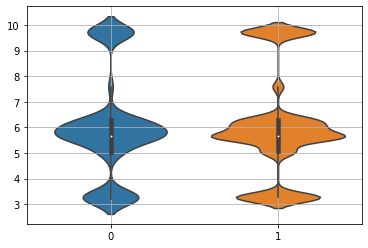

********************************************************************************
aa2_PI


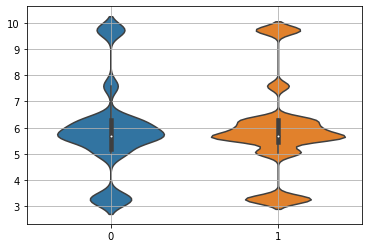

********************************************************************************
deltaPI


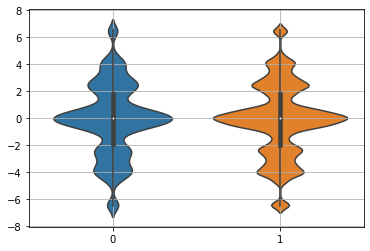

********************************************************************************
aa1_weight


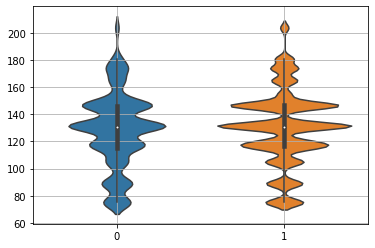

********************************************************************************
aa2_weight


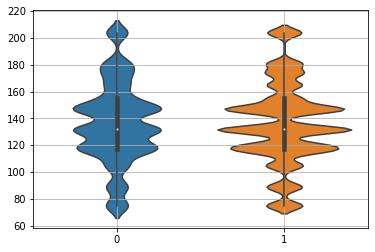

********************************************************************************
deltaWeight


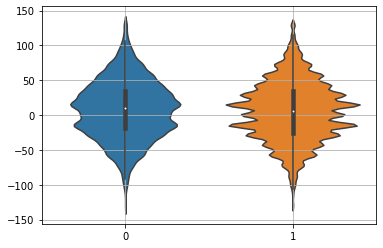

********************************************************************************
aa1vol


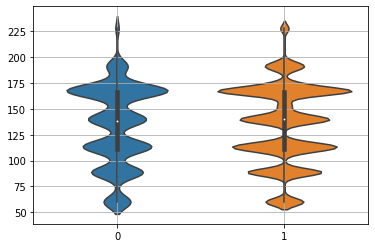

********************************************************************************
aa2vol


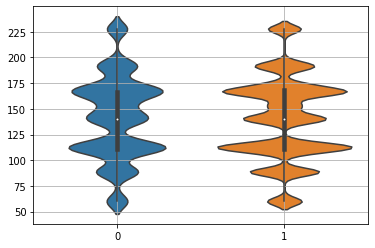

********************************************************************************
deltavolume


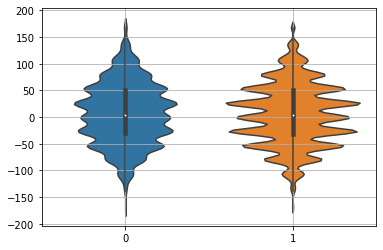

********************************************************************************
Grantham


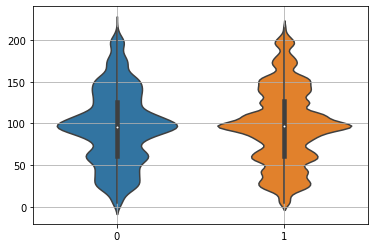

********************************************************************************
aa1_psic


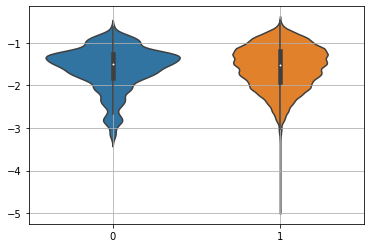

********************************************************************************
aa2_psic


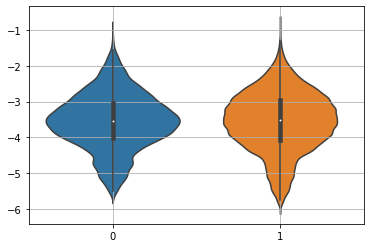

********************************************************************************
delta_psic


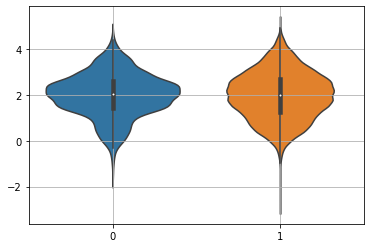

********************************************************************************
accessibility


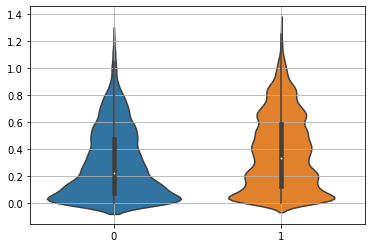

********************************************************************************
.     832
E    2333
G     539
H    3051
I      92
S     866
T    1279
Name: dssp_sec_str, dtype: int64
.     7999
B      307
E     7105
G     1234
H    13695
I      577
S     3452
T     4566
Name: dssp_sec_str, dtype: int64
********************************************************************************
?      18
A    4679
B    2807
L     146
P      19
a     320
b     312
g      14
l     239
p      45
Name: phi_psi_reg, dtype: int64
.       41
?      111
A    19313
B    12847
L      345
a     1720
b     2573
g      451
l     1386
p      148
Name: phi_psi_reg, dtype: int64
********************************************************************************
delta_solvent_accessibility


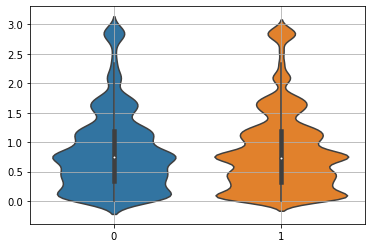

********************************************************************************
b_factor


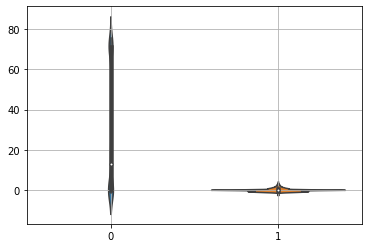

********************************************************************************
mut_msa_congruency


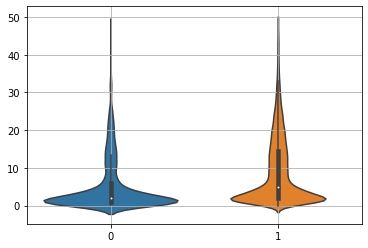

********************************************************************************
mut_mut_msa_congruency


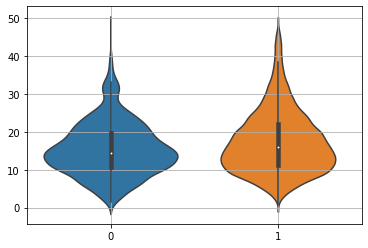

********************************************************************************
seq_ind_closest_mut


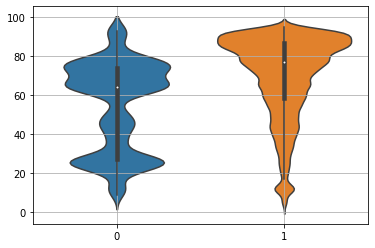

********************************************************************************
evolutionary_coupling_avg


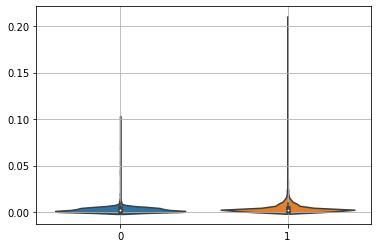

********************************************************************************


In [224]:
for col in paper.columns:
    if col in ['u_pos', 'uniprot_id', 'aa1', 'aa2', 'wt_mut']:
        continue
    if download[col].dtypes=='O':
        print(paper[col].value_counts().sort_index())
        print(download[col].value_counts().sort_index())
    else:
        print(col)
        sns.violinplot(data=[paper[col], download[col]])
        plt.grid()
        plt.show()
    print('*'*80)

## Supp table 1

In [149]:
collection = pd.read_excel('/Users/fu.j/AnacondaProjects/Project_3_extrapolation_model/data/dms_data/mavedb/220304/collection_criteria.xlsx',
                    index_col=0)
collection = collection[['urn', 'uniprot_id', 'short_description', 'collect_decision', 'forward_process', 'note']]
collection = collection.rename(columns={'urn': 'mavedb_urn'})

In [ ]:
dms_info = pd.read_excel('/Users/fu.j/AnacondaProjects/Project_3_extrapolation_model/data/dms_data/mavedb/221005/DMS_info.xlsx', 
              sheet_name='Picked_DMS')

In [142]:
import requests


mavedb_scoresets = requests.get("https://www.mavedb.org/api/scoresets/").json()
urn = []
short_description = []
for scoreset in mavedb_scoresets:
    urn.append(scoreset["urn"])
    short_description.append(scoreset["short_description"])
scoreset_info = pd.DataFrame({"mavedb_urn": urn, "short_description": short_description})

In [163]:
mave_info = pd.merge(dms_info[['uniprot_id', 'mavedb_urn', 'offset']], scoreset_info, on='mavedb_urn',
                     how='left', validate='1:1')
mave_info['included'] = True
mave_info = pd.merge(mave_info, collection, on=['mavedb_urn', 'uniprot_id', 'short_description'], 
                     how='outer', validate='1:1')
mave_info = mave_info.sort_values('mavedb_urn')

In [187]:
"""with pd.ExcelWriter("/Users/fu.j/OneDrive - wehi.edu.au/Alanine_scanning manuscript/supplementary/Supplementary_Table_1.xlsx") as writer:
    mave_info.to_excel(writer, sheet_name="MaveDB_DMS", index=None)  

    foo = dms_info.drop(columns='offset').sort_values(['protein_name', 'dms_name']).copy()
    foo.to_excel(writer, sheet_name='DMS_info', index=None)
    
    as_info = pd.read_csv('/Users/fu.j/AnacondaProjects/Project_3_extrapolation_model/data/as_data/221007/AS_info.csv')
    as_info = as_info.sort_values(['molecule_name', 'pmid'])
    as_info.to_excel(writer, sheet_name='AS_info', index=None)
    
    foo = data_info[data_info['Ascan_id'].notna()].sort_values(['protein_name', 'dms_name', 'Ascan_id']).drop(columns='offset')
    foo.to_excel(writer, sheet_name='DMS-AS_compatibility', index=None)"""

In [188]:
foo = data_info[data_info['Ascan_id'].notna()].sort_values(['protein_name', 'dms_name', 'Ascan_id']).drop(columns='offset')

In [194]:
foo[['assumed_compatibility','reason']].drop_duplicates().sort_values(['assumed_compatibility', 'reason'])

,assumed_compatibility,reason
246,High,Assays both select on protein general property.
232,High,Assays select on similar specific protein prop...
231,Low,AS assay does not fulfill the experimental dem...
330,Low,AS assay selects on drug response of the targe...
58,Low,AS assay selects on gain of new protein functi...
82,Low,AS assay selects on gain of new protein functi...
206,Low,AS has no effect according to the paper.
377,Low,DMS assay is under non-selective environment a...
405,Low,DMS assay selects on gain of new protein funct...
27,Low,Only one of the assay involves in pathogen inf...


In [193]:
foo.groupby(['reason'])['dmsa_id'].count()

reason
AS assay does not fulfill the experimental demand according to the paper                     1
AS assay selects on drug response of the target protein.                                    40
AS assay selects on gain of new protein function (infection of simian virus).                1
AS assay selects on gain of new protein function (novel antibody binding).                   4
AS has no effect according to the paper.                                                     9
AS selects under non-physical condition.                                                     9
Assays both select on protein general property.                                             21
Assays select on different yet specific protein properties.                                 44
Assays select on similar specific protein property.                                         82
DMS assay is under non-selective environment according to the paper.                         1
DMS assay selects on gain of new protein fu

In [200]:
foo.query("reason=='Assays select on similar specific protein property.'").dms_name.unique()

array(['ACE2-s-high', 'AICDA-G3', 'Abeta42', 'BRCA1_E3',
       'BRCA1_Starita_2018', 'CCR5-2d7-bind', 'CCR5-expression',
       'CCR5-gp120cd4-bind', 'CXCR4-12g5-bind', 'CXCR4-cxcl12-bind',
       'CXCR4-expression', 'GB1', 'GCN4-complete', 'GCN4-starvation',
       'JUN-full-trans', 'LamB-Maltodextrins', 'PTEN_Phosphatase',
       'RAF1-modify-10h', 'RAF1-modify-12h', 'RAF1-modify-24h',
       'RAF1-modify-2h', 'RAF1-modify-48h', 'RAF1-modify-4h',
       'RAF1-modify-6h', 'RAF1-modify-72h', 'RAF1-modify-8h'],
      dtype=object)

In [203]:
abnormal_dms = ['ACE2-s-high', 'CCR5-gp120cd4-bind', ]
                
normal_dms = ['AICDA-G3', 'Abeta42', 'BRCA1_E3',
       'BRCA1_Starita_2018', 'CCR5-2d7-bind', 'CCR5-expression','CXCR4-12g5-bind', 'CXCR4-cxcl12-bind',
       'CXCR4-expression', 'GB1', 'GCN4-complete', 'GCN4-starvation',
       'JUN-full-trans', 'LamB-Maltodextrins', 'PTEN_Phosphatase',
       'RAF1-modify-10h', 'RAF1-modify-12h', 'RAF1-modify-24h',
       'RAF1-modify-2h', 'RAF1-modify-48h', 'RAF1-modify-4h',
       'RAF1-modify-6h', 'RAF1-modify-72h', 'RAF1-modify-8h']
                
print(len(foo.query("reason=='Assays select on similar specific protein property.' & dms_name in @abnormal_dms")))
print(len(foo.query("reason=='Assays select on similar specific protein property.' & dms_name in @normal_dms")))

16
66
